# Visualizing and Animating positions

In [9]:
## Load in some dependencies
library(dplyr); library(data.table); library(ggplot2); library(ggforce)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [5]:
nhwl_df <- read.csv("../input/nhwldata/Rotman MMA Summer Datathon NWHL.csv")
head(nhwl_df)

,game_date,Home.Team,Away.Team,Period,Clock,Home.Team.Skaters,Away.Team.Skaters,Home.Team.Goals,Away.Team.Goals,Team,⋯,Event,X.Coordinate,Y.Coordinate,Detail.1,Detail.2,Detail.3,Detail.4,Player.2,X.Coordinate.2,Y.Coordinate.2
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,⋯,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,⋯,Faceoff Win,100,43,Backhand,,,,Stephanie Anderson,NA,NA
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,⋯,Puck Recovery,107,40,,,,,,NA,NA
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,⋯,Zone Entry,125,28,Carried,,,,Maddie Rowe,NA,NA
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,⋯,Shot,131,28,Snapshot,On Net,t,f,,NA,NA
5,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,⋯,Faceoff Win,169,21,Backhand,,,,Stephanie Anderson,NA,NA
6,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:52,5,5,0,0,Boston Pride,⋯,Puck Recovery,159,26,,,,,,NA,NA


In [8]:
nhwl_plays_df <- nhwl_df %>%
  filter(Event %in% c("Play", "Incomplete Play"), Detail.1 == "Direct", X.Coordinate >= 125, X.Coordinate.2 >= 125) %>%
  mutate(start_x = Y.Coordinate,
         start_y = X.Coordinate,
         end_x = Y.Coordinate.2,
         end_y = X.Coordinate.2,
         
         delta_x = end_x - start_x,
         delta_y = end_y - start_y,
         
         is_complete = ifelse(Event == "Play", 1, 0))

head(nhwl_plays_df,10)

,game_date,Home.Team,Away.Team,Period,Clock,Home.Team.Skaters,Away.Team.Skaters,Home.Team.Goals,Away.Team.Goals,Team,⋯,Player.2,X.Coordinate.2,Y.Coordinate.2,start_x,start_y,end_x,end_y,delta_x,delta_y,is_complete
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:43,5,5,0,0,Minnesota Whitecaps,⋯,Haley Mack,196,33,20,193,33,196,13,3,1
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:08,5,5,0,0,Minnesota Whitecaps,⋯,Nina Rodgers,161,14,10,168,14,161,4,-7,1
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,18:51,5,5,0,0,Boston Pride,⋯,McKenna Brand,175,47,65,195,47,175,-18,-20,0
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,18:36,5,5,0,0,Boston Pride,⋯,McKenna Brand,168,74,52,135,74,168,22,33,1
5,2021-01-23,Minnesota Whitecaps,Boston Pride,1,18:29,5,5,0,0,Boston Pride,⋯,Lauren Kelly,165,22,82,174,22,165,-60,-9,0
6,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:50,5,5,0,0,Minnesota Whitecaps,⋯,Haylea Schmid,180,48,53,199,48,180,-5,-19,1
7,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:40,5,5,0,0,Boston Pride,⋯,Samantha Davis,180,42,64,175,42,180,-22,5,0
8,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:38,5,5,0,0,Boston Pride,⋯,Taylor Turnquist,143,81,63,174,81,143,18,-31,1
9,2021-01-23,Minnesota Whitecaps,Boston Pride,1,16:32,5,5,0,0,Boston Pride,⋯,Samantha Davis,198,46,61,198,46,198,-15,0,1


## Clustering

In [11]:
cluster_fit <- kmeans(nhwl_plays_df %>% select(start_x: delta_y), centers = 50)
nhwl_plays_df$cluster <- cluster_fit$cluster

In [12]:
cluster_summary <- nhwl_plays_df %>%
  group_by(cluster) %>%
  summarise(total_passes = n(),
            comp_rate = mean(is_complete))

risky_passes <- (cluster_summary %>%
                   arrange(comp_rate) %>%
                   .$cluster)[1:3]

safe_passes <- (cluster_summary %>%
                   arrange(desc(comp_rate)) %>%
                   .$cluster)[1:3]

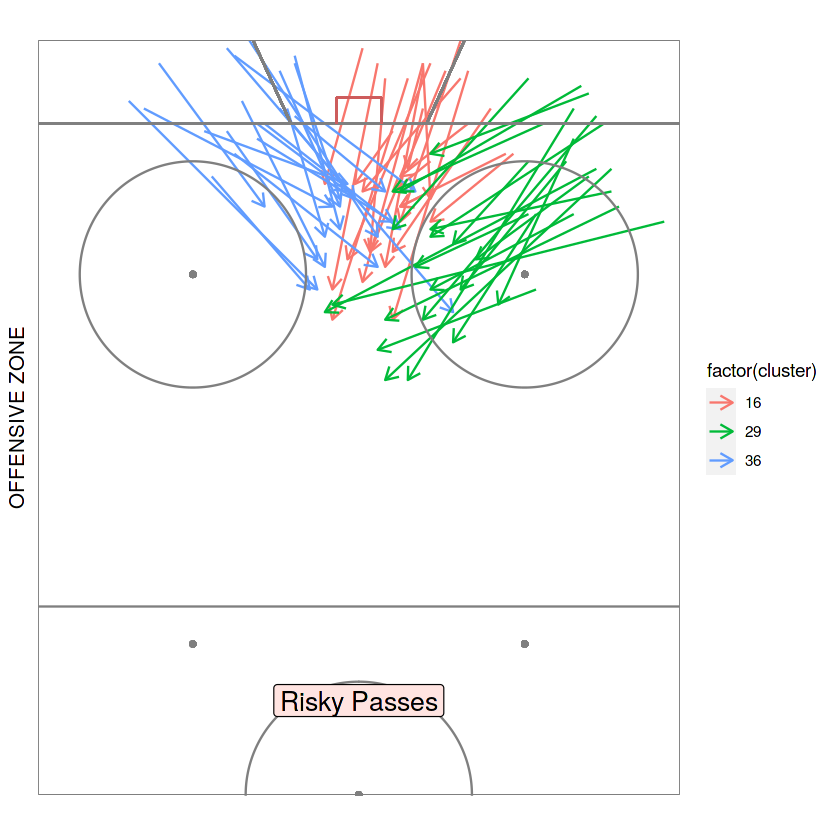

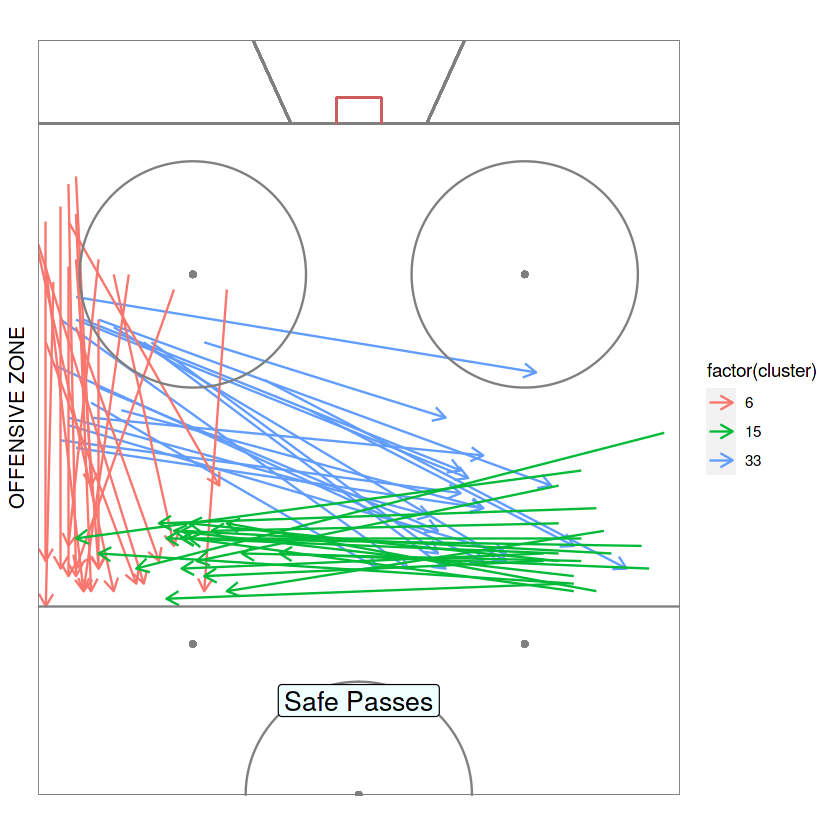

In [16]:
# Plot clusters
risky_dat <- bind_rows(nhwl_plays_df %>%
                         filter(cluster == risky_passes[1]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[2]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[3]) %>%
                         sample_n(20, replace = FALSE))


ggplot(data = risky_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Risky Passes", size = 5.5, fill = "mistyrose")


safe_dat <- bind_rows(nhwl_plays_df %>%
                        filter(cluster == safe_passes[1]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[2]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[3]) %>%
                        sample_n(20, replace = FALSE))


ggplot(data = safe_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Safe Passes", size = 5.5, fill = "azure")